Note: Use this template to develop your project. Do not change the steps. For each step, you may add additional cells if needed.

#### Group Information

Group No: 

- Member 1:
- Member 2:
- Member 3:
- Member 4:

#### Import Libraries

In [1]:
%config Completer.use_jedi=False
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pandas as pd

#### Load the dataset

In [2]:
dataset = pd.read_csv('classification_dataset.csv')

#### Define the loss function

In [3]:
def loss_fn(y, yhat):
    """
    This function calculates the loss function
    """
    epsilon = 1e-15
    yhat = tf.clip_by_value(yhat, epsilon, 1 - epsilon)
    
    # Binary cross-entropy loss
    return -tf.reduce_mean(y * tf.math.log(yhat) + (1 - y) * tf.math.log(1 - yhat))

#### Define function to perform prediction

In [4]:
def sigmoid(z):
    """ 
    This function calculates the sigmoid function.
    """
    return tf.math.sigmoid(z)

def relu(z):
    """ 
    This function calculates the ReLU function.
    """
    return tf.maximum(0.0, z)

def forward(W, B, x):
    """ 
    This function calculates the forward pass (predicts the label).
    """
    # First layer (hidden layer with ReLU activation)
    z1 = tf.matmul(x, W[0]) + B[0]
    a1 = relu(z1)
    
    # Output layer (with sigmoid activation)
    z2 = tf.matmul(a1, W[1]) + B[1]
    a2 = sigmoid(z2)
    
    return a2, a1

#### Define function for model training
Display the training and validation loss values for each epoch of the training loop. The displayed value must be in 6 decimal places.<br>
Hint: <br>
Use `tf.GradientTape` to compute the gradients.

In [5]:
def train(W, B, x, y, alpha):
    """ 
    This function performs the forward pass, computes the gradient and update the weights and biases.
    """
    with tf.GradientTape() as tape:
        # Forward pass
        yhat, hidden = forward(W, B, x)
        
        # Calculate loss
        loss = loss_fn(y, yhat)
    
    # Calculate gradients
    gradients = tape.gradient(loss, W + B)
    
    # Update weights and biases
    for i in range(len(W)):
        W[i].assign_sub(alpha * gradients[i])
        B[i].assign_sub(alpha * gradients[i + len(W)])
    
    return loss

def fit(model, train_ds, vald_ds, batch_size, alpha, max_epochs):
    """ 
    This function implements the training loop.
    """
    W, B = model
    X_train, y_train = train_ds
    X_val, y_val = vald_ds
    
    n_samples = X_train.shape[0]
    n_batches = int(np.ceil(n_samples / batch_size))
    
    train_losses = []
    val_losses = []
    
    for epoch in range(max_epochs):
        # Shuffle training data
        indices = tf.random.shuffle(tf.range(n_samples))
        X_shuffled = tf.gather(X_train, indices)
        y_shuffled = tf.gather(y_train, indices)
        
        # Training
        epoch_loss = 0
        for batch in range(n_batches):
            start_idx = batch * batch_size
            end_idx = min((batch + 1) * batch_size, n_samples)
            
            X_batch = X_shuffled[start_idx:end_idx]
            y_batch = y_shuffled[start_idx:end_idx]
            
            batch_loss = train(W, B, X_batch, y_batch, alpha)
            epoch_loss += batch_loss
        
        avg_train_loss = epoch_loss / n_batches
        
        # Validation
        yhat_val, _ = forward(W, B, X_val)
        val_loss = loss_fn(y_val, yhat_val)
        
        train_losses.append(avg_train_loss.numpy())
        val_losses.append(val_loss.numpy())
        
        # Print every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{max_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    return train_losses, val_losses

#### Define the tensors to hold the weights and biases (create the model)
Hint: <br>
Use `tf.Variable` to create the tensors.<br>
Put the tensors in a list.

In [8]:
input_dim = X_train.shape[1] 
hidden_units = 16 
output_dim = 1 

print(f"Model architecture: Input dim: {input_dim}, Hidden units: {hidden_units}, Output dim: {output_dim}")
W1 = tf.Variable(tf.random.normal([input_dim, hidden_units], stddev=0.1), name="W1")
B1 = tf.Variable(tf.zeros([hidden_units]), name="B1")
W2 = tf.Variable(tf.random.normal([hidden_units, output_dim], stddev=0.1), name="W2")
B2 = tf.Variable(tf.zeros([output_dim]), name="B2")

W = [W1, W2]
B = [B1, B2]
model = [W, B]

Model architecture: Input dim: 5, Hidden units: 16, Output dim: 1


#### Split the dataset
The ratio of training and test is 7:1:2.

In [7]:
X = dataset.iloc[:, :-1].values.astype(np.float32)  # First 5 columns are features
y = dataset.iloc[:, -1].values.astype(np.float32).reshape(-1, 1)  # Last column is the label

print(f"Data shape: {X.shape}, Labels shape: {y.shape}")

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size = 0.3, random_state = 42)

#second split dataset to 10% validation and 20% test 
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=(2/3), random_state=42)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

Data shape: (1000, 5), Labels shape: (1000, 1)
Training set: (700, 5)
Validation set: (100, 5)
Test set: (200, 5)


#### Normalize the data

In [9]:
def normalize(X_train, X_val, X_test):
    mean = np.mean(X_train, axis = 0)
    std = np.std(X_train, axis = 0)
    
    X_train_norm = (X_train - mean) / std
    X_val_norm = (X_val - mean) / std
    X_test_norm = (X_test - mean) / std
    
    return X_train_norm, X_val_norm, X_test_norm
X_train_norm, X_val_norm, X_test_norm =(normalize(X_train, X_val, X_test))
X_train_norm = tf.convert_to_tensor(X_train_norm)
X_val_norm = tf.convert_to_tensor(X_val_norm)
X_test_norm = tf.convert_to_tensor(X_test_norm)

#### Train the model

In [10]:
batch_size = 32
learning_rate = 0.01
epochs = 100

train_losses, val_losses = fit(model, (X_train_norm, y_train), (X_val_norm, y_val), batch_size, learning_rate, epochs)

Epoch 10/100, Train Loss: 0.6387, Val Loss: 0.6343
Epoch 20/100, Train Loss: 0.5335, Val Loss: 0.5235
Epoch 30/100, Train Loss: 0.3883, Val Loss: 0.3777
Epoch 40/100, Train Loss: 0.2687, Val Loss: 0.2613
Epoch 50/100, Train Loss: 0.1917, Val Loss: 0.1857
Epoch 60/100, Train Loss: 0.1458, Val Loss: 0.1368
Epoch 70/100, Train Loss: 0.1197, Val Loss: 0.1062
Epoch 80/100, Train Loss: 0.1032, Val Loss: 0.0866
Epoch 90/100, Train Loss: 0.0929, Val Loss: 0.0734
Epoch 100/100, Train Loss: 0.0863, Val Loss: 0.0639


#### Display the training loss and validation loss against epoch graph

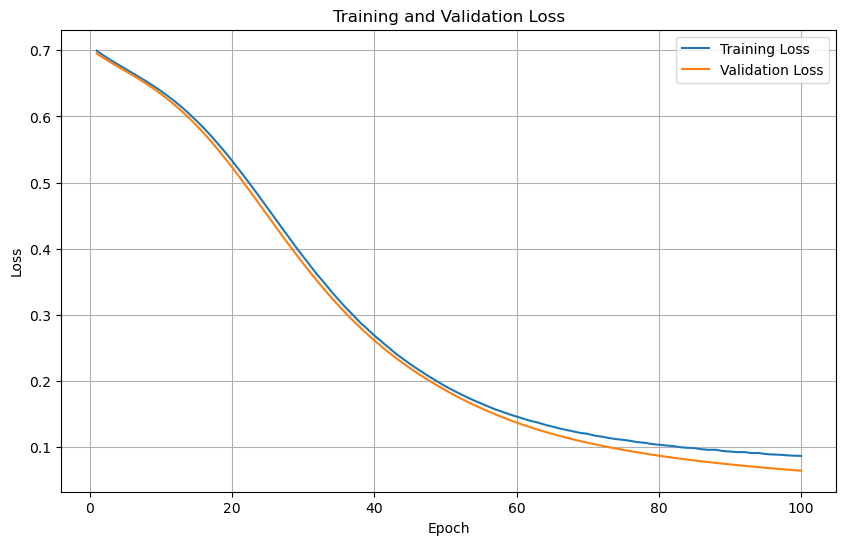

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

#### Predict the test set

In [12]:
y_pred_prob, _ = forward(W, B, X_test_norm)
y_pred = tf.cast(y_pred_prob > 0.5, tf.float32).numpy()
y_true = y_test

#### Display the confusion matrix and the classification report.

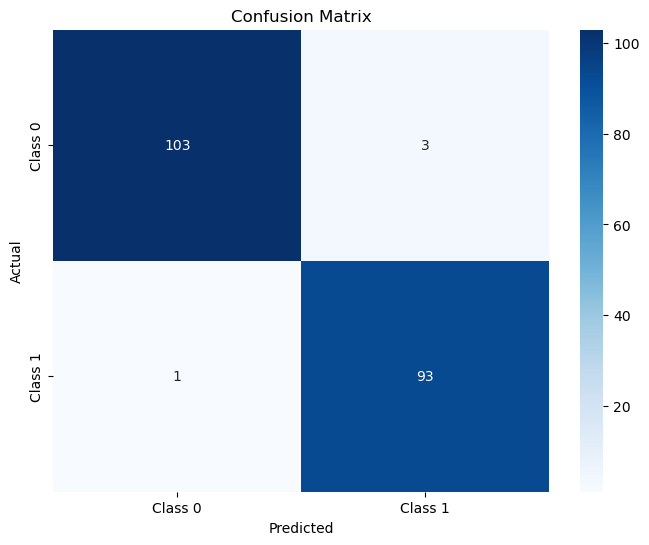


Classification Report:
              precision    recall  f1-score   support

     Class 0       0.99      0.97      0.98       106
     Class 1       0.97      0.99      0.98        94

    accuracy                           0.98       200
   macro avg       0.98      0.98      0.98       200
weighted avg       0.98      0.98      0.98       200


Test Accuracy: 0.9800


In [13]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Class 0', 'Class 1'], 
            yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1']))

# Calculate test accuracy
test_accuracy = np.mean(y_pred == y_true)
print(f"\nTest Accuracy: {test_accuracy:.4f}")